## Task 2.2: Supervised preprocessing

**Author**: Andre Schomakers

**Date**: 21 Mar 2025

This interactive Python notebook `.ipynb` is used for supervised preprocessing for task 2.1 on the `food.csv` dataset, see below:


https://corgis-edu.github.io/corgis/csv/food/

**Sources**:

[[1]](https://medium.com/@nirajan.acharya777/understanding-outlier-removal-using-interquartile-range-iqr-b55b9726363e) Acharya via Medium (2024): Understanding Outlier Removal Using Interquartile Range (IQR). Accessed on 21 Mar, 2025.

[[2]](https://towardsdatascience.com/using-the-chi-squared-test-for-feature-selection-with-implementation-b15a4dad93f1/) Goswarmi (2020): Using the Chi-Squared test for feature selection with implementation

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2, SelectKBest


In [2]:
# read csv data with pandas
df = pd.read_csv("diabetes.csv")

# getting an overview
df.shape # (768, 9)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preg    768 non-null    int64  
 1   plas    768 non-null    int64  
 2   pres    768 non-null    int64  
 3   skin    768 non-null    int64  
 4   insu    768 non-null    int64  
 5   mass    768 non-null    float64
 6   pedi    768 non-null    float64
 7   age     768 non-null    int64  
 8   class   768 non-null    object 
dtypes: float64(2), int64(6), object(1)
memory usage: 54.1+ KB


In [3]:
df.head()
# we can see different type of variables:
    # mass & pedi float
    # all other int (except for our binary target == class)

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,tested_positive
1,1,85,66,29,0,26.6,0.351,31,tested_negative
2,8,183,64,0,0,23.3,0.672,32,tested_positive
3,1,89,66,23,94,28.1,0.167,21,tested_negative
4,0,137,40,35,168,43.1,2.288,33,tested_positive


### IQR-based Outlier Detection
I've found a straight-forward Medium article for inspiration, see sources above [1].
Before removing the outliers, visual inspection via boxplots make sense.


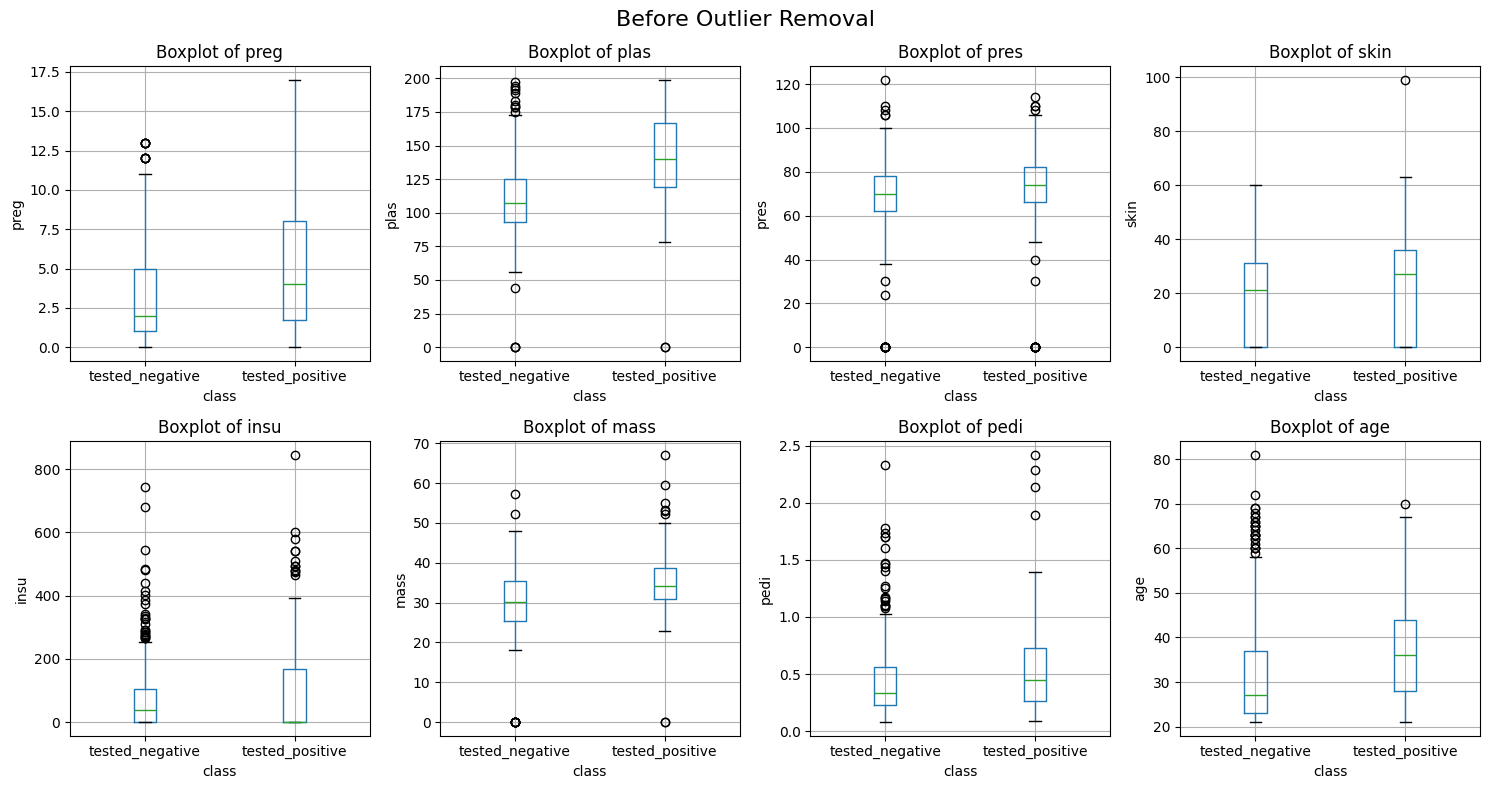

In [4]:
# create boxplot for only numeric cols
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# as we use this plot again, actually a function would be even more suitable for this code (to call later on, but skipped anyway)

# calc grid layout for subplot orga
n_cols = 4
n_rows = (len(numeric_columns) + n_cols - 1) // n_cols

# create boxplot for each num col
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten() if n_rows > 1 or n_cols > 1 else [axes]

for i, col in enumerate(numeric_columns):
    df.boxplot(column=col, by='class', ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_ylabel(col)
fig.suptitle('Before Outlier Removal', fontsize=16)

plt.tight_layout()
plt.show()

# we can see many outliers beyond the whiskers for several variables, most noticable for the "insu" & "pedi" vars.

In [5]:
# function from Medium article:
def remove_outliers_iqr(data, threshold=1.5):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    outliers_removed = data[(data >= lower_bound) & (data <= upper_bound)]
    return outliers_removed

In [6]:
# some variables have "0"-values where it doesnt make too much sense (in my opinion)
    # plas (plasma glucose?)
    # pres (blood pressure, when i compare values of the .describe() out)
    # insu (insulin)
    # mass (bmi?)
    # = data dictionary would be perfect to varify, but we skipp on that, removing these 0 vals (by casting as NaN)

df.describe()

,preg,plas,pres,skin,insu,mass,pedi,age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


In [7]:
# apply to df copy:
df_cleaned = df.copy()
# use the .apply()-method to use our fx on col batch
df_cleaned[numeric_columns] = df_cleaned[numeric_columns].apply(remove_outliers_iqr)

zero_as_nan_cols = ['plas', 'pres', 'insu', 'mass']
# convert zeros to NaN in those columns
for col in zero_as_nan_cols:
    df_cleaned.loc[df_cleaned[col] == 0, col] = np.nan

df_cleaned.shape # shape remains the same => outliers casted to NaN need to be removed

(768, 9)

In [8]:
df.isna().sum().sum() # before outlier removal: 0 NaNs
df_cleaned.isna().sum().sum() # after outlier removal: 520 NaNs

# remove them
df_final = df_cleaned.dropna()

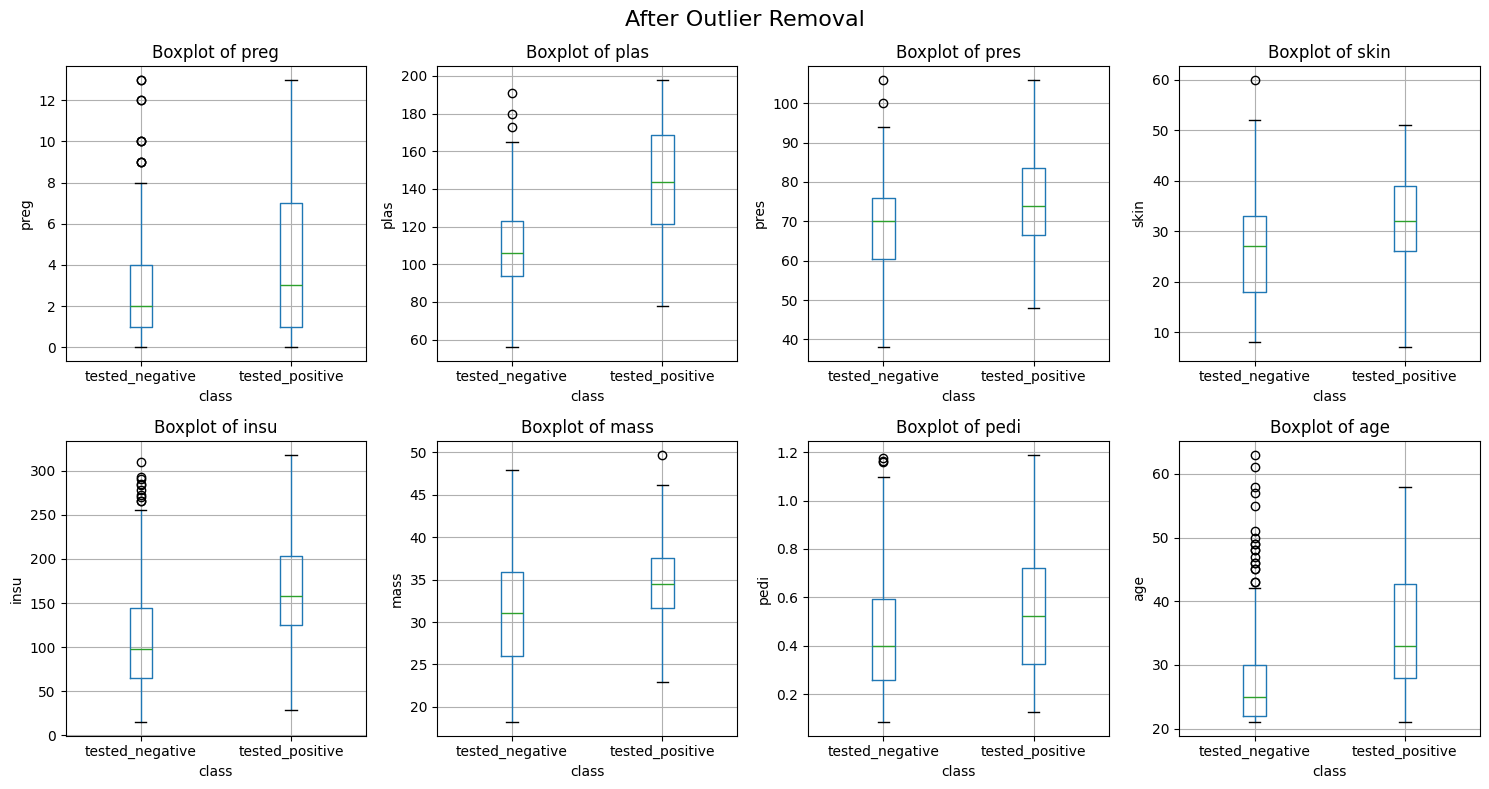

In [9]:
# boxplots for each col after outlier removal (on df_final)
numeric_columns = df_final.select_dtypes(include=['int64', 'float64']).columns.tolist()

n_cols = 4
n_rows = (len(numeric_columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten() if n_rows > 1 or n_cols > 1 else [axes]

for i, col in enumerate(numeric_columns):
    df_final.boxplot(column=col, by='class', ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_ylabel(col)

fig.suptitle('After Outlier Removal', fontsize=16)

plt.tight_layout()
plt.show()

# even if there are way less outliers (using 1.5 threshold), there are some outliers left for age (by testing negative class)
# and preg (e.g 12, 10 pregnancies) and so on. 

In [10]:
# instead of the description of a single variable, all vars can be inspected by using the .describe()-method
df_final.describe()

,preg,plas,pres,skin,insu,mass,pedi,age
count,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000
mean,3.177711,118.903614,70.722892,28.424699,126.897590,32.426807,0.473250,30.225904
std,3.023830,29.214227,11.403941,10.316021,66.660852,6.380974,0.252859,9.418446
min,0.000000,56.000000,38.000000,7.000000,15.000000,18.200000,0.085000,21.000000
25%,1.000000,97.750000,62.000000,20.000000,74.750000,27.800000,0.267750,23.000000
50%,2.000000,114.500000,70.000000,28.000000,115.500000,32.850000,0.430000,27.000000
75%,5.000000,136.250000,78.000000,36.000000,168.500000,36.500000,0.646250,35.250000
max,13.000000,198.000000,106.000000,60.000000,318.000000,49.700000,1.189000,63.000000


In [11]:
# pull target from X
X = df_final.drop('class', axis=1)
y = df_final['class']

In [12]:
# https://towardsdatascience.com/using-the-chi-squared-test-for-feature-selection-with-implementation-b15a4dad93f1/

# why feature selection:
    # models are more interpretable
    # model training faster and less space allocated
    # chi² => hypothesis testing: h_0 = feature is not important, h_a = feature is important
    # feature interaction wont be considered into this method

chi2_selector = SelectKBest(chi2, k='all')
fitted = chi2_selector.fit(X, y) #fit chi² to X and label

In [13]:
# extract chi²-vals and p-vals
chi2_scores = fitted.scores_
p_values = fitted.pvalues_

In [14]:
# create a df of features and their chi-squared scores
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Chi2_Score': chi2_scores,
    'P_Value': p_values
})

In [23]:
feature_scores # without prior scaling
sorted_features = feature_scores.sort_values('Chi2_Score', ascending=False) # sort them for better visibilty
sorted_features
# we can see, "insu" is the most discriminat var (smallest p-value as well)
# "pedi" the least discriminant var ("highest p-value")

,Feature,Chi2_Score,P_Value
4,insu,1482.62984667,0.00000000
1,plas,638.06141563,0.00000000
7,age,121.15910724,0.00000000
0,preg,59.94345488,0.00000000
3,skin,52.82086647,0.00000000
2,pres,26.00623620,0.00000034
5,mass,21.86504650,0.00000293
6,pedi,1.58318599,0.20830237


Text(0, 0.5, 'pedi')

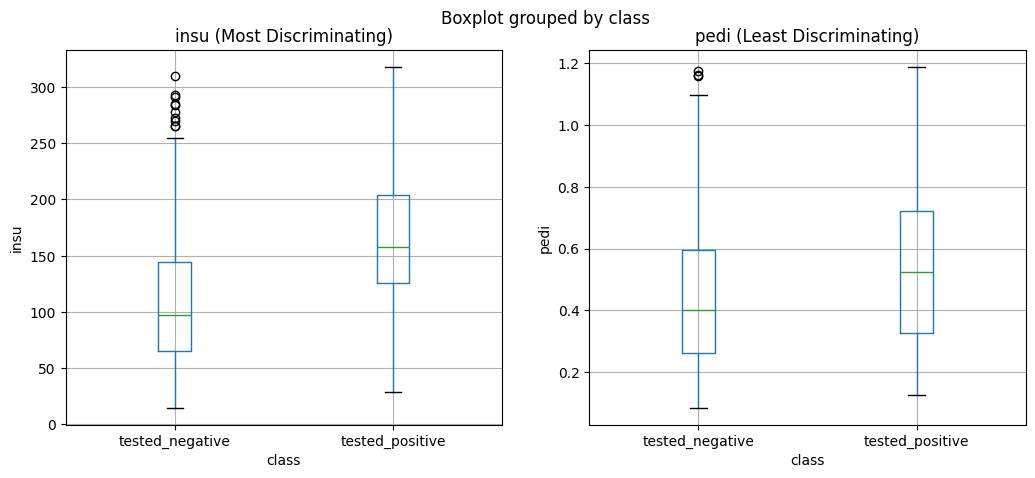

In [21]:
most_discriminating = sorted_features.iloc[0]['Feature']
least_discriminating = sorted_features.iloc[-1]['Feature']


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Most discriminating feature boxplot
df_final.boxplot(column=most_discriminating, by='class', ax=axes[0])
axes[0].set_title(f'{most_discriminating} (Most Discriminating)')
axes[0].set_ylabel(most_discriminating)

# Least discriminating feature boxplot
df_final.boxplot(column=least_discriminating, by='class', ax=axes[1])
axes[1].set_title(f'{least_discriminating} (Least Discriminating)')
axes[1].set_ylabel(least_discriminating)

So finally, the insulin feature `insu` is the feature most discriminating our target class. The least discriminating feature is `pedi` yielding a $p\,$-value of 0.20 (not significant == $H_0$ cannot be rejected for the least descriminating variable, therefore no relationsship is assumed, and without an relationship, predictive capabiliity is also not assumed and the `pedi` feature can be dumped from feature set.)

It can also be seen in the boxplot, that for `pedi`, the distribution of both classes overlapp each other probably leading to the low chi² value. 